In [20]:
import pandas as pd
import matplotlib.pyplot as plt

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

import icu
from polyglot.detect import Detector

In [3]:
data_path = './data_yelp/raw/json/yelp_academic_dataset_review.json'
# Reading the first line of the review dataset json
with open(data_path) as f:
    first_line = f.readline()
    print(first_line)

{"review_id":"Q1sbwvVQXV2734tPgoKj4Q","user_id":"hG7b0MtEbXx5QzbzE6C_VA","business_id":"ujmEBvifdJM6h6RLv4wQIg","stars":1.0,"useful":6,"funny":1,"cool":0,"text":"Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.","date":"2013-05-07 04:34:36"}



In [4]:
from data_preprocesser import split_raw_csv_review_file

#split_raw_csv_review_file(lines_per_file=100000, max_files=20 , join_business=True)

In [5]:
from data_preprocesser import preprocessed_data_path
import ast
from collections import Counter

def get_categories_count_file(filepath):
    df = pd.read_csv(filepath)
    test = []
    for x in df['categories']:
        try:
            x = x.replace(';',',')
        except:
            test.append('')
        else:
            test.append(x)
    df['categories'] = test
    slist = [st for row in df['categories'] for st in row.split(',') if len(row.split(','))<=5]
    return Counter(slist)

def get_categories_count():
    counter = Counter()
    for i in range(20):
        filepath = preprocessed_data_path + 'yelp_academic_dataset_review_split/yelp_academic_dataset_review_{}.csv'.format((i+1)*100000)
        counter = counter + get_categories_count_file(filepath)
    return (counter.most_common(100))

In [34]:
cat = get_categories_count()

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


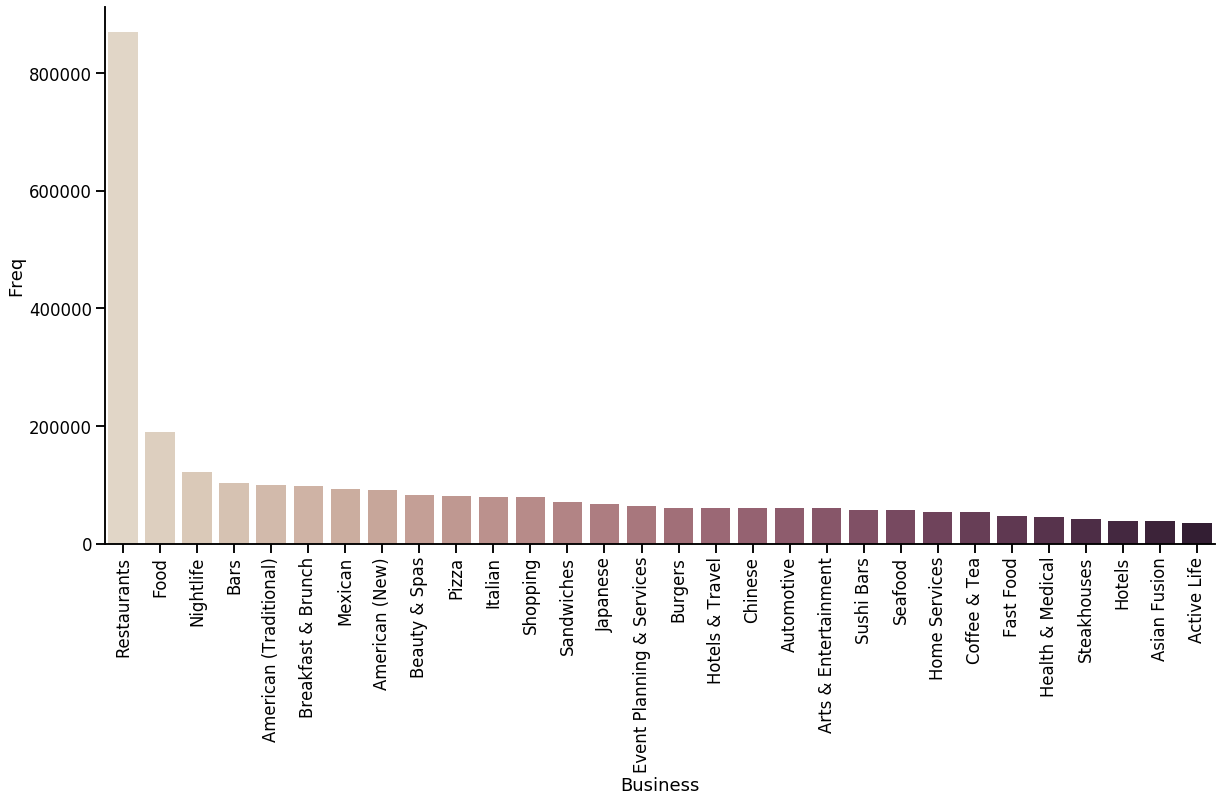

In [48]:
import seaborn as sns
df = pd.DataFrame(cat, columns=['Business', 'Freq'])

chart = sns.catplot(x="Business", y="Freq", kind="bar", palette="ch:.25", data=df.head(30))
chart.fig.set_size_inches(30,10)
sns.set_context("talk")

for ax in chart.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)


plt.show()

In [5]:
categories = ['Restaurants', 'Health & Medical', 'Hair Salons', 'Auto Repair']

In [32]:
from data_preprocesser import create_file

business_types = {
    "Restaurants" : pd.DataFrame(), 
    "Health & Medical" : pd.DataFrame(), 
    "Hair Salons" : pd.DataFrame(), 
    "Auto Repair" : pd.DataFrame()
}

threshold = 30000
create_file(preprocessed_data_path + 'categories_{}/'.format(threshold))

for i in range(20):
    print("File " +str(i))
    filepath = preprocessed_data_path + 'yelp_academic_dataset_review_split/yelp_academic_dataset_review_{}.csv'.format((i+1)*100000)
    df = pd.read_csv(filepath, index_col=[0])
    business_types_list = list(business_types.keys())
    for key in business_types_list:
        if business_types[key].shape[0] < threshold:
            other_keys = [x for x in business_types_list if x != key]
            filter_func = lambda s: key in s and not any(x in s for x in other_keys)
            df_temp = df
            df_temp['test'] = df_temp['categories'].apply(filter_func)
            df_temp = df_temp[df_temp['test']]
            df_temp.drop(columns=['test'], inplace=True)
            # Check the language
            df_temp['poly_obj'] = df_temp.text.apply(lambda x: Detector(x, quiet=True))
            df_temp['Text-Lang'] = df_temp['poly_obj'].apply(lambda x: icu.Locale.getDisplayName(x.language.locale))
            df_temp['Text-LangConfidence'] = df_temp['poly_obj'].apply(lambda x: x.language.confidence)
            df_temp = df_temp[df_temp['Text-Lang']=='anglais']
            df_temp.drop(columns=['poly_obj', 'Text-Lang', 'Text-LangConfidence'], inplace=True)
            #
        
            business_types[key] = pd.concat([business_types[key], df_temp], ignore_index = True)

for key in business_types_list:
    business_types[key] = business_types[key].head(threshold)
    business_types[key].to_csv(preprocessed_data_path + 
                               'categories_{}/yelp_academic_dataset_review_{}.csv'
                               .format(threshold, key), 
                               index=False
                              )
    


File 0


FileNotFoundError: [Errno 2] File b'./data_yelp/preprocessed/yelp_academic_dataset_review_split/yelp_academic_dataseloooot_review_100000.csv' does not exist: b'./data_yelp/preprocessed/yelp_academic_dataset_review_split/yelp_academic_dataseloooot_review_100000.csv'